In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from data335 import lm, bambi_lm, stan_lm, plot_regression_line

In [2]:
congress = pd.read_csv("../data/congress.csv")

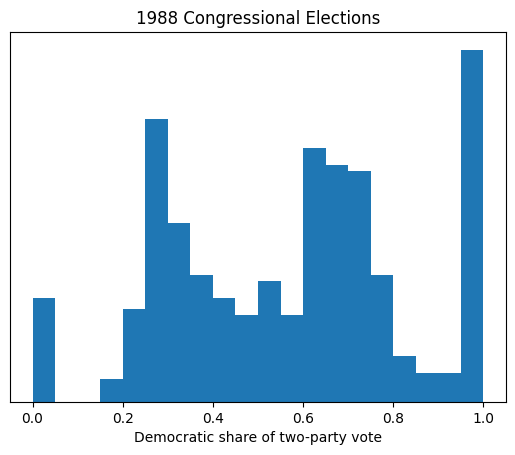

In [5]:
plt.hist(congress["v88"], bins=20, ec="black")
plt.title("1988 Congressional Elections")
plt.xlabel("Democratic share of two-party vote")
plt.yticks([])
plt.show()

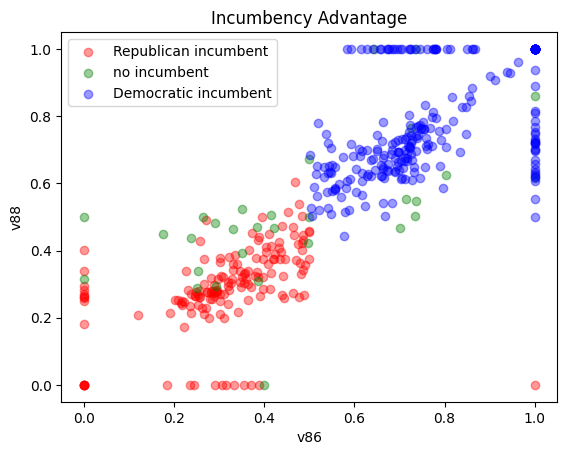

In [7]:
color = {-1: "red", 0: "green", 1: "blue"}
label = {-1: "Republican incumbent", 0: "no incumbent", 1: "Democratic incumbent"}
for inc, group in congress.groupby("inc88"):
    plt.scatter(
        group["v86"], group["v88"], color=color[inc], label=label[inc], alpha=0.4
    )
    plt.legend()
plt.title("Incumbency Advantage")
plt.xlabel("v86")
plt.ylabel("v88")
plt.show()

##### Preprocessing

- Remove uncontested 1988 elections. (Not hard to predict the outcome of an uncontested election!)
- *Impute* vote shares for uncontested 1986 elections &mdash; 0.25 (resp., 0.75) for a Republican (resp., a Democrat) running uncontested.

In [32]:
def preprocess(year, past_year):
    data = (
        congress[[f"v{year}", f"v{past_year}", f"inc{year}"]]
        .rename(
            columns={
                f"v{year}": "vote",
                f"v{past_year}": "past_vote",
                f"inc{year}": "inc",
            }
        )
        .copy()
    )
    data.loc[data["past_vote"] == 0, "past_vote"] = 0.25
    data.loc[data["past_vote"] == 1, "past_vote"] = 0.75
    unc_rep = data["vote"] == 0
    unc_dem = data["vote"] == 1
    is_contested = np.logical_and(~unc_rep, ~unc_dem)
    assert sum(is_contested) + sum(unc_rep), sum(unc_dem) == len(congress)
    return data[is_contested], sum(unc_rep), sum(unc_dem)

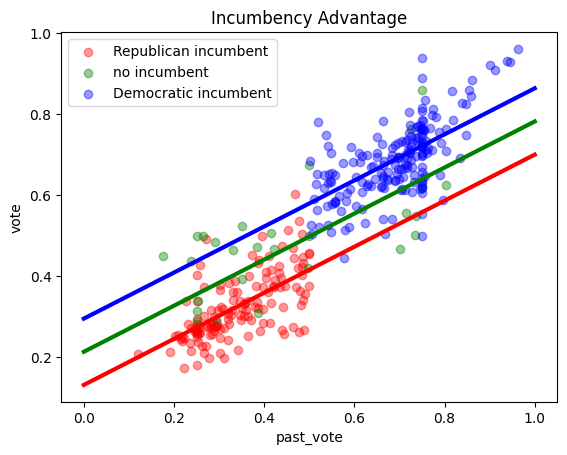

In [28]:
data88, num_unc_rep, num_unc_dem = preprocess("88", "86")

fit = lm("vote ~ past_vote + inc", data88)
coef_1, coef_past_vote, coef_inc = fit.coef_est

for inc, group in data88.groupby("inc"):
    plt.scatter(
        group["past_vote"], group["vote"], color=color[inc], label=label[inc], alpha=0.4
    )
    plot_regression_line(
        (coef_1 + coef_inc * inc, coef_past_vote), color=color[inc], lw=3, xlim=(0, 1)
    )
plt.legend()
plt.title("Incumbency Advantage")
plt.xlabel("past_vote")
plt.ylabel("vote")

plt.show()

In [33]:
data90, num_unc_rep, num_unc_dem = preprocess("90", "88")
data90

,vote,past_vote,inc
0,0.714029,0.772443,1
1,0.597050,0.636182,1
2,0.521043,0.664928,0
3,0.234377,0.273834,-1
4,0.477439,0.263613,0
...,...,...,...
430,0.750401,0.763288,1
431,0.437871,0.291337,-1
432,0.480790,0.373454,-1
433,0.607843,0.440967,0


In [40]:
vote_pred = fit.predict(data90)
sum(vote_pred > 0.5) + num_unc_dem

260

In [87]:
fit = bambi_lm("vote ~ past_vote + inc", data88)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, past_vote, inc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [88]:
vote_pred = fit.posterior_predict(data88)
np.sum(vote_pred > 0.5, axis=1)

array([256, 258, 258, ..., 259, 258, 256])

In [5]:
data88 = pd.DataFrame(
    dict(vote=congress["v88_adj"], past_vote=congress["v86_adj"], inc=congress["inc88"])
)
fit = bambi_lm("vote ~ past_vote + inc", data88)
fit

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, past_vote, inc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,median,mad_sd
sigma,0.067230,0.002284
Intercept,0.237870,0.017036
past_vote,0.521433,0.032947
inc,0.096372,0.006734


In [9]:
vote_pred = fit.posterior_predict(data88)
np.sum(vote_pred > 0.5, axis=1)

array([256, 256, 259, ..., 256, 256, 258])

In [7]:
data90 = pd.DataFrame(
    dict(vote=congress["v90_adj"], past_vote=congress["v88_adj"], inc=congress["inc90"])
)
vote_pred = fit.posterior_predict(data90)

In [8]:
vote_pred = fit.posterior_predict(data90)
np.sum(vote_pred > 0.5, axis=1)

array([260, 260, 260, ..., 260, 260, 260])

In [97]:
np.sum(vote_pred > 0.5, axis=1)

array([260, 260, 260, ..., 260, 260, 260])